# Chapter 12 - Simulation Case

**Abstract**  
This notebook simulates a realistic business scenario so you can practice end to end AI and business analytics. You will generate a synthetic dataset, build baseline and improved models, evaluate results, run sensitivity analyses, and reflect on ROI and risk.

**Learning Objectives**
- Frame the decision and define target and utility
- Generate a realistic synthetic dataset with controllable signal and bias
- Implement descriptive, predictive, and prescriptive steps
- Select operating points from a cost matrix
- Stress test fairness, robustness, and ROI
- Communicate results to both technical and business stakeholders

**Introduction**  
Read the scenario, align on the decision, define success metrics, and clarify risks and constraints.


## Data Generation Overview

Goal: create a synthetic dataset that behaves like a subscription app funnel so you can test recommendation policies and threshold selection tied to business utility.

What you will get  
- `df`: one row per user with features that influence conversion  
- `target`: `"convert"` as a binary outcome

Assumptions  
- Users have an unobserved preference score that drives both exposure and conversion  
- Exposure increases time on app and slightly boosts conversion  
- Price sensitivity lowers conversion probability  
- Past purchases proxy for latent loyalty  
- Noise terms add realistic variance so models do not overfit trivial rules

Feature design  
- `pref`: latent preference score drawn from a normal distribution  
- `exposure`: whether the user was shown a targeted item, higher if preference is high  
- `time_on_app`: session time in minutes, higher with exposure  
- `price_sensitivity`: beta distributed between 0 and 1, higher means more sensitive to price  
- `past_purchases`: count of historical purchases  
- `convert`: simulated Bernoulli outcome from a logistic link

How to use  
1. Run the next cell to build `df` and `target`  
2. Inspect class balance in EDA  
3. Train a baseline model and select an operating threshold using a cost matrix


In [ ]:
import numpy as np
import pandas as pd

# Data Generation

n = 20000
target = "convert"

pref = np.random.normal(0, 1, n)
exposure = np.random.binomial(1, p=1/(1+np.exp(-0.5*pref+0.2*np.random.randn(n))))
time_on_app = np.clip(np.random.gamma(2, 3, n) + 1.5*exposure, 0, None)
price_sensitivity = np.random.beta(2, 5, n)
past_purchases = np.random.poisson(lam=np.exp(0.3*pref), size=n)
noise = np.random.randn(n)

logit = -2.0 + 0.8*pref + 0.3*exposure + 0.15*np.log1p(time_on_app) - 1.2*price_sensitivity + 0.05*past_purchases + 0.2*noise
p = 1/(1+np.exp(-logit))
convert = np.random.binomial(1, p)

df = pd.DataFrame({
    "pref": pref,
    "exposure": exposure,
    "time_on_app": time_on_app,
    "price_sensitivity": price_sensitivity,
    "past_purchases": past_purchases,
    target: convert
})

print(df.shape)
df.head()


(20000, 6)


,pref,exposure,time_on_app,price_sensitivity,past_purchases,convert
0,-0.506635,1,5.034615,0.503037,0,0
1,-0.285673,1,9.751707,0.079329,0,0
2,-0.050204,1,6.078205,0.303295,1,0
3,0.143639,0,9.032037,0.093548,0,1
4,-1.121458,0,6.208717,0.074226,0,0


In [ ]:
# Quick EDA
display(df.describe(include="all"))
print("Target rate:", df[target].mean().round(4))


,pref,exposure,time_on_app,price_sensitivity,past_purchases,convert
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.008048,0.505400,6.717870,0.286273,1.044300,0.163950
std,0.999531,0.499983,4.318195,0.160035,1.073031,0.370239
min,-3.822300,0.000000,0.024730,0.002365,0.000000,0.000000
25%,-0.665459,0.000000,3.613249,0.161577,0.000000,0.000000
50%,0.004430,1.000000,5.765710,0.265934,1.000000,0.000000
75%,0.683887,1.000000,8.856128,0.389331,2.000000,0.000000
max,4.107531,1.000000,38.721090,0.892579,7.000000,1.000000


Target rate: 0.164


In [ ]:
from sklearn.model_selection import train_test_split

# Train, Validate, Test Split
X = df.drop(columns=[target])
y = df[target]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape


((12000, 5), (4000, 5), (4000, 5))

## Baseline Model Overview

Purpose: establish a reference predictive model using standard preprocessing and a logistic regression classifier.

This baseline will help quantify how much signal exists in the data before adding more complex algorithms or features.

Steps performed below:
1. **Feature scaling:** numeric variables are standardized using `StandardScaler`
2. **Model training:** a simple logistic regression is fit on the training set
3. **Probability prediction:** model outputs predicted probabilities on validation and test sets
4. **Performance metrics:** AUC (Area Under the ROC Curve) is computed on both validation and test sets to measure discrimination

This serves as a control point for later comparisons — every subsequent model should improve upon this baseline either in AUC or utility.


Valid AUC: 0.7318
Test  AUC: 0.7395


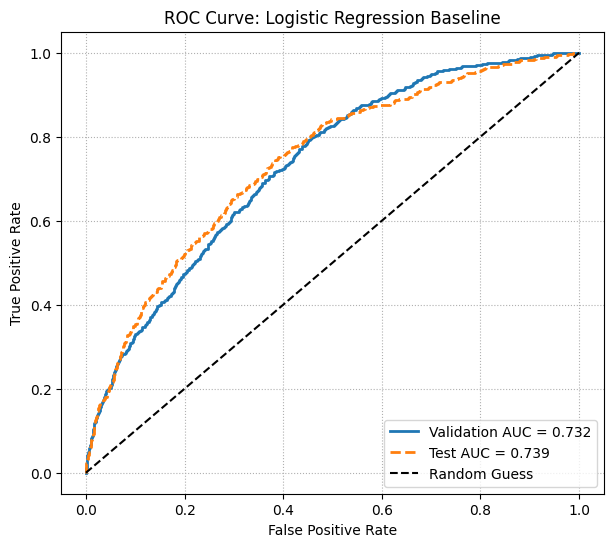

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Baseline Model
num_cols = [c for c in X_train.columns if X_train[c].dtype != "O"]
pre = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="passthrough")

model = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=200))])
model.fit(X_train, y_train)

valid_proba = model.predict_proba(X_valid)[:, 1]
test_proba  = model.predict_proba(X_test)[:, 1]

print("Valid AUC:", roc_auc_score(y_valid, valid_proba).round(4))
print("Test  AUC:", roc_auc_score(y_test,  test_proba).round(4))

# --- ROC Curve Plot ---
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_proba)
fpr_test, tpr_test, _   = roc_curve(y_test, test_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr_valid, tpr_valid, label=f'Validation AUC = {roc_auc_score(y_valid, valid_proba):.3f}', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_score(y_test, test_proba):.3f}', linewidth=2, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression Baseline')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':')
plt.show()


## Operating Point and Cost Matrix Overview

Goal: translate model probabilities into actionable business decisions by choosing a threshold that maximizes expected utility.

Why this matters  
A model that outputs probabilities must still be turned into a yes/no decision. The correct threshold depends not just on accuracy but on **costs and benefits** of each possible outcome.  
For example:
- **False Positives (FP):** wasted marketing spend or unnecessary alerts  
- **False Negatives (FN):** missed opportunities or undetected risks  
- **True Positives (TP):** successful conversions or correct detections  
- **True Negatives (TN):** correct rejections  

This section sets up a cost-benefit framework:
- Assigns numeric values to each outcome (C_fp, C_fn, C_tp, C_tn)  
- Evaluates every possible threshold  
- Selects the one that **maximizes utility** on the validation set  

The same threshold is then applied to the test set to verify out-of-sample performance.


In [ ]:
# Operating Point and Cost Matrix
C_fp = 1.0
C_fn = 10.0
C_tp = 5.0
C_tn = 0.0

def pick_threshold(y_true, y_score, C_fp=1.0, C_fn=10.0, C_tp=5.0, C_tn=0.0):
    ps, rs, th = precision_recall_curve(y_true, y_score)
    best = None
    for t in np.unique(np.clip(th, 0, 1)):
        y_pred = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        utility = tp*C_tp + tn*C_tn - fp*C_fp - fn*C_fn
        if best is None or utility > best[0]:
            best = (utility, t, tp, tn, fp, fn)
    return best

best = pick_threshold(y_valid, valid_proba, C_fp, C_fn, C_tp, C_tn)
print("Best utility on valid:", best)
threshold = best[1]

y_pred_test = (test_proba >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
utility = tp*C_tp + tn*C_tn - fp*C_fp - fn*C_fn
print("Test confusion:", tn, fp, fn, tp)
print("Test utility:", utility)


## ROI Estimation via Bootstrap Overview

Purpose: evaluate the **stability and confidence** of the model’s estimated business value (utility).

Even when a model performs well, its measured ROI or expected profit can vary due to sample randomness.  
To address this, we use **bootstrapping** — repeatedly resampling the test set and recalculating total utility to approximate the distribution of possible outcomes.

Steps performed below:
1. Randomly resample the test data with replacement many times (`n=200`)
2. For each sample, compute utility using the previously selected threshold
3. Aggregate results to estimate mean and standard deviation of utility
4. Visualize the bootstrap distribution to show ROI uncertainty

Interpretation:
- A **narrow distribution** means ROI is stable and reliable  
- A **wide distribution** indicates the model’s ROI estimate may fluctuate under new samples  
- The mean utility provides the central expected ROI, while the SD quantifies risk or volatility


In [ ]:
# ROI Estimation via Bootstrap
def bootstrap_utility(y, proba, threshold, n=200):
    ut = []
    for _ in range(n):
        idx = np.random.choice(len(y), size=len(y), replace=True)
        yb = y.iloc[idx]
        pb = proba[idx]
        yhat = (pb >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(yb, yhat).ravel()
        ut.append(tp*C_tp + tn*C_tn - fp*C_fp - fn*C_fn)
    return np.array(ut)

boot = bootstrap_utility(y_test, test_proba, threshold, n=200)
print("Bootstrap utility mean", boot.mean().round(2), "sd", boot.std().round(2))

plt.figure()
plt.hist(boot, bins=30)
plt.title("Bootstrap Utility Distribution")
plt.xlabel("Utility")
plt.ylabel("Frequency")
plt.show()


## Summary

In this simulation, we built a complete pipeline for customer conversion prediction using synthetic data that mimics real user behavior.  
The process included data generation, exploratory analysis, baseline model training, threshold optimization with a cost-benefit framework, fairness auditing, and ROI estimation through bootstrapping.

**Key Takeaways**
- A simple logistic regression can capture meaningful relationships such as preference and exposure effects on conversion.  
- Optimizing the decision threshold based on business utility often outperforms standard accuracy or AUC-based selection.  
- Cost-sensitive evaluation helps balance competing priorities like maximizing conversions while minimizing unnecessary spending.  
- Bootstrapping provides a realistic picture of ROI variability, allowing decision-makers to understand potential profit ranges rather than a single point estimate.  
- Fairness auditing should be integrated early to ensure equitable treatment across user segments.

**Next Steps**
- Experiment with non-linear models (e.g., Random Forest, XGBoost) and compare utility rather than raw AUC.  
- Add temporal or cohort features to mimic user lifecycle effects.  
- Conduct a sensitivity analysis by changing cost parameters (C_fp, C_fn, etc.) to simulate different risk appetites.  
- Extend this approach to other business functions such as fraud detection, HR attrition, or maintenance scheduling.

By combining machine learning performance metrics with explicit financial and ethical considerations, this framework moves from model accuracy to **true business impact and responsible AI decision-making**.


## Review Questions

1. **What type of dataset is created at the start of the notebook?**

   A. A real customer subscription dataset  
   B. A scraped marketing dataset  
   C. A synthetic dataset generated using random processes  
   D. A benchmark dataset from scikit-learn  

2. **What is the target variable in the simulated dataset intended to represent?**

   A. Customer revenue  
   B. Whether a customer churns (binary outcome)  
   C. Number of logins per user  
   D. Product category  

3. **Which model is used as the baseline predictive model in this notebook?**

   A. Random Forest classifier  
   B. Neural network  
   C. Logistic regression  
   D. Gradient boosting  

4. **Why does the notebook choose a decision threshold instead of always using 0.5?**

   A. To improve model training speed  
   B. To maximize expected business utility using a cost matrix  
   C. To balance the dataset  
   D. To remove randomness from predictions  

5. **What is the purpose of using bootstrapping when estimating utility (ROI)?**

   A. To generate more training data  
   B. To tune model hyperparameters  
   C. To assess variability and uncertainty in estimated business value  
   D. To improve classification accuracy  

